In [6]:
G_path = '/Users/sepehrbe/My_Drive/DataSources/Project_Data'
import pandas as pd
import seaborn as sns
from sklearn import *
import sklearn as sk
from sklearn import *
import numpy as np
from scipy.stats import chi2_contingency
import datetime as dt
import pickle
import torch
import json
import random
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from MLP_Nets import MLP_Nets

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from usefull_functions import *
import time
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

In [7]:
image_label = 'image_label'  #[image_label, binary_label]

# 280x210
file = 'CNN_280x210_Ouput_MultiClass'
data = pd.read_pickle(G_path + '/07_CNNs_Output_DataSet/' + file)

blc_test_list = pickle.load(open(G_path + '/02_Augmented_MetaData/balanced_test_set','rb'))
# Evaluation_set = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))

train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']
blc_test_data = data.merge(blc_test_list['image_id'], how='inner',on='image_id')


train_label = train_data[image_label]
train_data = train_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
valid_label = valid_data[image_label]
valid_data = valid_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
test_label = test_data[image_label]
test_data = test_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])
blc_label = blc_test_data[image_label]
blc_data = blc_test_data.drop(columns=['image_id','image_label','dx','lesion_id','type','binary_label'])

train_data_arrays = np.stack(train_data.values)  
train_label_arrays = np.stack(train_label.values)
train_label_arrays_One = pd.get_dummies(train_label_arrays).values  

valid_data_arrays = np.stack(valid_data.values)  
valid_label_arrays = np.stack(valid_label.values)  
valid_label_arrays_One = pd.get_dummies(valid_label_arrays).values  

test_data_arrays = np.stack(test_data.values)  
test_label_arrays = np.stack(test_label.values)  
test_label_arrays_One = pd.get_dummies(test_label_arrays).values  

blc_data_arrays = np.stack(blc_data.values)  
blc_label_arrays = np.stack(blc_label.values)  
blc_label_arrays_One = pd.get_dummies(blc_label_arrays).values 

#Numpy Arrays
input_data_Array = (train_data_arrays , valid_data_arrays, test_data_arrays , np.concatenate((train_data_arrays,valid_data_arrays )))
labels_Array = (train_label_arrays,valid_label_arrays,test_label_arrays, np.concatenate((train_label_arrays,valid_label_arrays)))
labels_One_Array = (train_label_arrays_One,valid_label_arrays_One,test_label_arrays_One, np.concatenate((train_label_arrays_One,valid_label_arrays_One)))

# Tensors
def to_Torch(x):
    return torch.tensor(x,dtype= torch.float32)

input_data_Tensor = (to_Torch(train_data_arrays),to_Torch(valid_data_arrays)  , to_Torch(test_data_arrays) , to_Torch(np.concatenate((train_data_arrays,valid_data_arrays))))
labels_Tensor = (to_Torch(train_label_arrays),to_Torch(valid_label_arrays),to_Torch(test_label_arrays) , to_Torch(np.concatenate((train_label_arrays,valid_label_arrays))) )
labels_OneHot_Tensor = (to_Torch(train_label_arrays_One),to_Torch(valid_label_arrays_One),to_Torch(test_label_arrays_One), to_Torch(np.concatenate((train_label_arrays_One,valid_label_arrays_One))))

blc_data_Tensor = (to_Torch(blc_data_arrays))

In [8]:
train_label_arrays, train_data['CNN_0'].max()

(array([2, 2, 1, ..., 5, 4, 5], dtype=int8), 0.99732554)

# **Random Forrest**

In [9]:
Model_ = sk.ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = False
nr_repeat =1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'log2'],
    'max_depth' : [20,30],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [False],
    'class_weight' : [None, 'balanced'],
    'max_leaf_nodes' : [5,None],
}

RF_Model, RF_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(RF_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'RF_Model' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 640/640
              precision    recall  f1-score   support

           0       0.52      0.70      0.59        23
           1       0.55      0.69      0.61        32
           2       0.64      0.68      0.66        72
           3       0.67      0.50      0.57         8
           4       0.58      0.47      0.52        62
           5       0.88      0.85      0.87       200
           6       0.90      0.90      0.90        10

    accuracy                           0.73       407
   macro avg       0.68      0.68      0.67       407
weighted avg       0.74      0.73      0.74       407

Best param:  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 200}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.7346437346437347


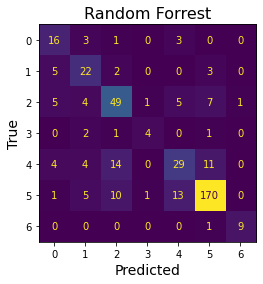

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,51.6%,69.6%,96.1%,59.3%
1,7.9%,55.0%,68.8%,95.2%,61.1%
2,17.7%,63.6%,68.1%,91.6%,65.8%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,58.0%,46.8%,93.9%,51.8%
5,49.1%,88.1%,85.0%,88.9%,86.5%
6,2.5%,90.0%,90.0%,99.7%,90.0%
Simple Avg.,nan%,67.6%,68.3%,95.0%,67.4%
Weighted Avg.,nan%,74.1%,73.5%,91.5%,73.5%


In [10]:
# Model 280x210
model_ = RF_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'Random Forrest')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [11]:
Model_ = sk.ensemble.RandomForestClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = False
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [20],
    'criterion' :['gini'],
    'bootstrap': [False],
    'class_weight' : [None,],
    'max_leaf_nodes' : [None],
}

RF_Model_CM, RF_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(RF_Model_CM, open(G_path + '/Saved/Models/Classifiers/' + 'RF_Model_CV' , 'wb'))
    pickle.dump(RF_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'RF_Model_CV' , 'wb'))


------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.50      0.65      0.57        23
           1       0.56      0.69      0.62        32
           2       0.64      0.65      0.65        72
           3       0.67      0.50      0.57         8
           4       0.48      0.44      0.46        62
           5       0.89      0.85      0.87       200
           6       0.90      0.90      0.90        10

    accuracy                           0.72       407
   macro avg       0.66      0.67      0.66       407
weighted avg       0.73      0.72      0.73       407

Best param:  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 200}


# **SVM**

In [12]:
Model_ = sk.svm.SVC(random_state=0)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = False
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'C' : [2,5,10]
    ,'kernel': ['rbf', 'linear'],
    'degree' : [1,3,7],
    'gamma' :['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr'],
    'class_weight' : [None, 'balanced']
}

SVM_Model, SVM_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(SVM_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'SVM_Model' , 'wb'))
    

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 1440/1440
              precision    recall  f1-score   support

           0       0.50      0.65      0.57        23
           1       0.56      0.69      0.62        32
           2       0.64      0.69      0.67        72
           3       0.67      0.50      0.57         8
           4       0.53      0.45      0.49        62
           5       0.89      0.85      0.87       200
           6       0.82      0.90      0.86        10

    accuracy                           0.73       407
   macro avg       0.66      0.68      0.66       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'C': 2, 'class_weight': None, 'decision_function_shape': 'ovr', 'degree': 7, 'gamma': 'scale', 'kernel': 'rbf'}


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Nr. of Data : 
 407
Accuracy of The Model : 
 0.7321867321867321


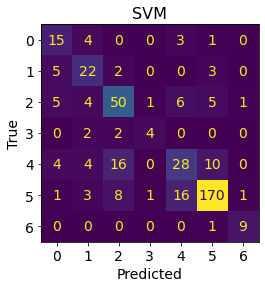

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,50.0%,65.2%,96.1%,56.6%
1,7.9%,56.4%,68.8%,95.5%,62.0%
2,17.7%,64.1%,69.4%,91.6%,66.7%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,52.8%,45.2%,92.8%,48.7%
5,49.1%,89.5%,85.0%,90.3%,87.2%
6,2.5%,81.8%,90.0%,99.5%,85.7%
Simple Avg.,nan%,65.9%,67.7%,95.0%,66.3%
Weighted Avg.,nan%,73.9%,73.2%,92.1%,73.4%


In [13]:
# Model 280x210
model_ = SVM_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'SVM')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [14]:
Model_ = sk.svm.SVC(random_state=0)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = False
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'C' : [10]
    ,'kernel': ['rbf'],
    'degree' : [1],
    'gamma' :['scale'],
    'decision_function_shape': ['ovo'],
    'class_weight' : [None]
}

SVM_Model_CV, SVM_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(SVM_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'SVM_Model_CV' , 'wb'))
    pickle.dump(SVM_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'SVM_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.50      0.65      0.57        23
           1       0.54      0.69      0.60        32
           2       0.66      0.68      0.67        72
           3       0.67      0.50      0.57         8
           4       0.54      0.44      0.48        62
           5       0.88      0.85      0.87       200
           6       0.82      0.90      0.86        10

    accuracy                           0.73       407
   macro avg       0.66      0.67      0.66       407
weighted avg       0.73      0.73      0.73       407

Best param:  {'C': 10, 'class_weight': None, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


# **Guassian NB**

In [15]:
Model_ = sk.naive_bayes.GaussianNB()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_mode = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'priors': [None],
    'var_smoothing': [0,4e-1,5e-1,3e-1, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

GB_Model, GB_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=1)

if save_model:
    pickle.dump(GB_Model, open(G_path + '/Saved/Models/Classifiers/' + 'GB_Model' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 170/170
              precision    recall  f1-score   support

           0       0.48      0.52      0.50        23
           1       0.48      0.69      0.56        32
           2       0.66      0.46      0.54        72
           3       1.00      0.50      0.67         8
           4       0.41      0.56      0.48        62
           5       0.85      0.80      0.82       200
           6       1.00      0.80      0.89        10

    accuracy                           0.67       407
   macro avg       0.70      0.62      0.64       407
weighted avg       0.70      0.67      0.68       407

Best param:  {'priors': None, 'var_smoothing': 0.4}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.6732186732186732


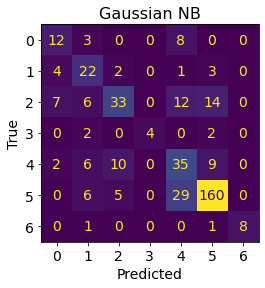

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,48.0%,52.2%,96.6%,50.0%
1,7.9%,47.8%,68.8%,93.6%,56.4%
2,17.7%,66.0%,45.8%,94.9%,54.1%
3,2.0%,100.0%,50.0%,100.0%,66.7%
4,15.2%,41.2%,56.5%,85.5%,47.6%
5,49.1%,84.7%,80.0%,86.0%,82.3%
6,2.5%,100.0%,80.0%,100.0%,88.9%
Simple Avg.,nan%,69.7%,61.9%,93.8%,63.7%
Weighted Avg.,nan%,70.4%,67.3%,89.3%,68.0%


In [16]:
# Model 280x210
model_ = GB_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'Gaussian NB')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [17]:
Model_ = sk.naive_bayes.GaussianNB()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_mode = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'priors': [None],
    'var_smoothing': [5e-1]
}

GB_Model_CV, GB_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=10)

if save_model:
    pickle.dump(GB_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'GB_Model_CV' , 'wb'))
    pickle.dump(GB_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'GB_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.48      0.52      0.50        23
           1       0.50      0.69      0.58        32
           2       0.67      0.44      0.53        72
           3       1.00      0.38      0.55         8
           4       0.42      0.52      0.46        62
           5       0.81      0.83      0.82       200
           6       1.00      0.60      0.75        10

    accuracy                           0.67       407
   macro avg       0.70      0.57      0.60       407
weighted avg       0.69      0.67      0.67       407

Best param:  {'priors': None, 'var_smoothing': 0.5}


# **MLP**

In [18]:
Model_ = sk.neural_network.MLPClassifier()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {
    'hidden_layer_sizes': [(50,60,50),(40,60,30)],
    'random_state':[0],
    'activation': [ 'relu'],
    'solver': ['sgd',],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : 10.00 ** -np.arange(2, 4)
}

MLP_Model, MLP_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)
if save_model:
    pickle.dump(MLP_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'MLP_Model' , 'wb'))
    

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 80/80
              precision    recall  f1-score   support

           0       0.52      0.70      0.59        23
           1       0.53      0.62      0.57        32
           2       0.61      0.71      0.65        72
           3       0.67      0.50      0.57         8
           4       0.54      0.44      0.48        62
           5       0.90      0.84      0.87       200
           6       0.90      0.90      0.90        10

    accuracy                           0.73       407
   macro avg       0.67      0.67      0.66       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (40, 60, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'random_state': 0, 'solver': 'sgd'}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.7272727272727273


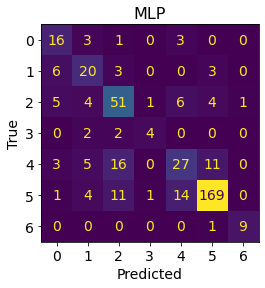

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,51.6%,69.6%,96.1%,59.3%
1,7.9%,52.6%,62.5%,95.2%,57.1%
2,17.7%,60.7%,70.8%,90.1%,65.4%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,54.0%,43.5%,93.3%,48.2%
5,49.1%,89.9%,84.5%,90.8%,87.1%
6,2.5%,90.0%,90.0%,99.7%,90.0%
Simple Avg.,nan%,66.5%,67.3%,95.0%,66.3%
Weighted Avg.,nan%,73.7%,72.7%,92.1%,72.9%


In [19]:
# Model 280x210
model_ = MLP_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'MLP')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [20]:
Model_ = sk.neural_network.MLPClassifier()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {
    'hidden_layer_sizes': [(50,60,50)],
    'random_state':[0],
    'activation': [ 'relu'],
    'solver': ['sgd',],
    'alpha': [0.0001],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : [1e-2]
}

MLP_Model_CV, MLP_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)
if save_model:
    pickle.dump(MLP_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'MLP_Model_CV' , 'wb'))
    pickle.dump(MLP_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'MLP_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.55      0.70      0.62        23
           1       0.52      0.69      0.59        32
           2       0.67      0.64      0.65        72
           3       0.67      0.50      0.57         8
           4       0.52      0.48      0.50        62
           5       0.89      0.85      0.87       200
           6       0.90      0.90      0.90        10

    accuracy                           0.73       407
   macro avg       0.67      0.68      0.67       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 60, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'random_state': 0, 'solver': 'sgd'}


# **KNN**

In [21]:
Model_ = neighbors.KNeighborsClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_neighbors': [7,8,12],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'leaf_size' : [20,25],
    'p' : [1,2,5]
}

KNN_Model, KNN_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(KNN_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'KNN_Model' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 1440/1440
              precision    recall  f1-score   support

           0       0.42      0.57      0.48        23
           1       0.64      0.66      0.65        32
           2       0.65      0.74      0.69        72
           3       0.71      0.62      0.67         8
           4       0.52      0.55      0.53        62
           5       0.92      0.83      0.87       200
           6       1.00      0.70      0.82        10

    accuracy                           0.73       407
   macro avg       0.69      0.67      0.67       407
weighted avg       0.76      0.73      0.74       407

Best param:  {'algorithm': 'brute', 'leaf_size': 25, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.7346437346437347


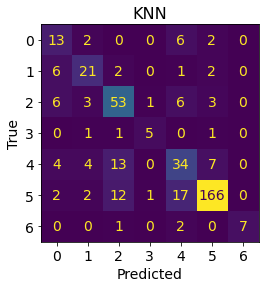

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,41.9%,56.5%,95.3%,48.1%
1,7.9%,63.6%,65.6%,96.8%,64.6%
2,17.7%,64.6%,73.6%,91.3%,68.8%
3,2.0%,71.4%,62.5%,99.5%,66.7%
4,15.2%,51.5%,54.8%,90.7%,53.1%
5,49.1%,91.7%,83.0%,92.8%,87.1%
6,2.5%,100.0%,70.0%,100.0%,82.4%
Simple Avg.,nan%,69.3%,66.6%,95.2%,67.3%
Weighted Avg.,nan%,75.6%,73.5%,93.0%,74.2%


In [22]:
# Model 280x210
model_ = KNN_Model
X = input_data_Array[2]
Y = labels_Array[2]
# X = blc_data_arrays
# Y = blc_label_arrays
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'KNN')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [23]:
Model_ = neighbors.KNeighborsClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_neighbors': [8],
    'weights': ['distance'],
    'algorithm': ['auto'],
    'leaf_size' : [25],
    'p' : [2]
}

KNN_Model_CV, KNN_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(KNN_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'KNN_Model_CV' , 'wb'))
    pickle.dump(KNN_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'KNN_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.38      0.52      0.44        23
           1       0.61      0.59      0.60        32
           2       0.68      0.74      0.71        72
           3       0.71      0.62      0.67         8
           4       0.48      0.47      0.48        62
           5       0.89      0.85      0.87       200
           6       1.00      0.90      0.95        10

    accuracy                           0.73       407
   macro avg       0.68      0.67      0.67       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'algorithm': 'auto', 'leaf_size': 25, 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}


# **Biased Classifier**

In [24]:
Dum_class = sk.dummy.DummyClassifier(strategy="most_frequent" )

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

Dum_class.fit(X_train, Y_train)

Y = Y_test
Y_pred = Dum_class.predict(X_test)

print(sk.metrics.classification_report(Y,Y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        62
           5       0.49      1.00      0.66       200
           6       0.00      0.00      0.00        10

    accuracy                           0.49       407
   macro avg       0.07      0.14      0.09       407
weighted avg       0.24      0.49      0.32       407



In [25]:
test_recall_weighed, test_specificity_weighed, _ = recall_specificity_precision(Y,Y_pred,weighted_avg=True)

In [26]:
Model_ = sk.dummy.DummyClassifier(strategy="most_frequent" )
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {}

Biased_Model_CV, Biased_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(Biased_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'Biased_Model_CV' , 'wb'))
    pickle.dump(Biased_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'Biased_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        62
           5       0.49      1.00      0.66       200
           6       0.00      0.00      0.00        10

    accuracy                           0.49       407
   macro avg       0.07      0.14      0.09       407
weighted avg       0.24      0.49      0.32       407

Best param:  {}


In [27]:
CNN_Rescaled_Details = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'CNN_Rescaled_Details_MultiClass' ,'rb'))
CNN_A_E_Details = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'CNN_A_E_Details_MultiClass' ,'rb'))

In [28]:
c = 'test_recall_weighed'
df = [CNN_A_E_Details,CNN_Rescaled_Details,RF_Details_CV,SVM_Details_CV,MLP_Details_CV,GB_Details_CV,KNN_Details_CV,Biased_Details_CV]
clss_name = ['CNN-A.E.','CNN-Resc.','RF','SVM','MLP','GB','KNN','Biased']
df_0 = pd.DataFrame()
for i in range(0, len(df)):
    df_00 = pd.DataFrame(df[i][c].values, columns=[clss_name[i]])
    df_0 = pd.concat([df_0,df_00],axis=1)

Sensitivity = df_0

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


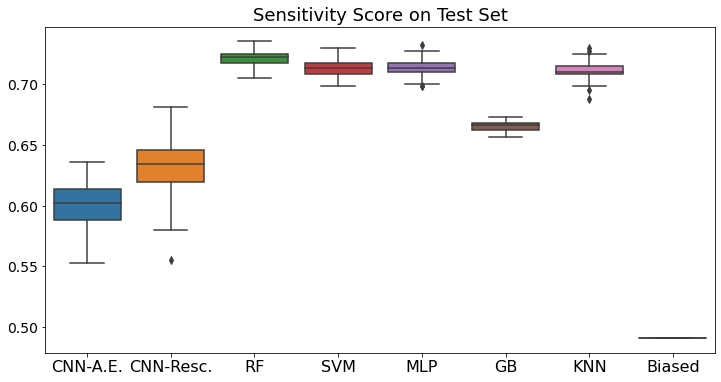

In [29]:
plt.subplots(figsize=(12,6))
sns.boxplot(data=Sensitivity)
plt.title('Sensitivity Score on Test Set',fontsize = 18)
# plt.xlabel("Classifiers", fontsize = 14)
# plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

In [30]:
c = 'test_specificity_weighed'
df = [CNN_A_E_Details,CNN_Rescaled_Details,RF_Details_CV,SVM_Details_CV,MLP_Details_CV,GB_Details_CV,KNN_Details_CV,Biased_Details_CV]
clss_name = ['CNN-A.E.','CNN-Resc.','RF','SVM','MLP','GB','KNN','Biased']
df_0 = pd.DataFrame()
for i in range(0, len(df)):
    df_00 = pd.DataFrame(df[i][c].values, columns=[clss_name[i]])
    df_0 = pd.concat([df_0,df_00],axis=1)

specificity = df_0

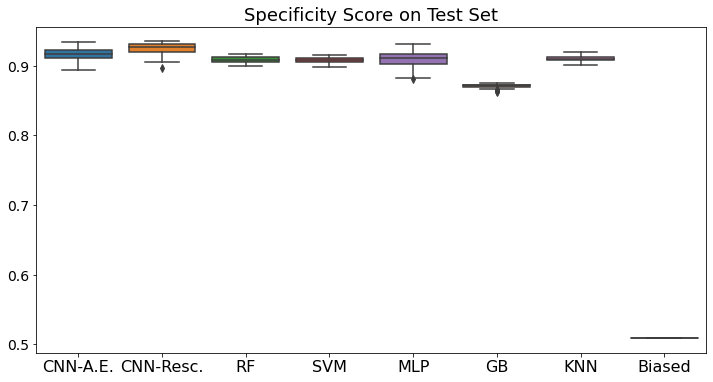

In [31]:
plt.subplots(figsize=(12,6))
sns.boxplot(data=specificity)
plt.title('Specificity Score on Test Set',fontsize = 18)
# plt.xlabel("Classifiers", fontsize = 14)
# plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()